# Mesh Interpolation

### Goal

Demonstrate the use of `dhitools` to load and inspect a DHI MIKE unstructured `.mesh` file, and interpolate multiple raster digital elevation models (DEMs) in GeoTIFF format to the mesh.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

from dhitools import mesh

----
## tl;dr

Minimum steps to interpolate mesh

In [2]:
mesh_f = 'data/example_mesh_no_elevation.mesh' # Mesh files
dem_dir = 'data/DEM' # DEM files
dem_data = [os.path.join(dem_dir,f) for f in os.listdir(dem_dir) if f.endswith('tif')] # List with path to each DEM
m = mesh.Mesh(mesh_f) # Load mesh
m.interpolate_rasters(dem_data) # Interpolate mesh
m.write_mesh('data/interpolated_mesh.mesh') # Save interpolated mesh

----

## Outline

- Load and inspect `.mesh` file
- Interpolate topographic and bathymetric data
- Write new `.mesh`

## Load and Inspect Mesh

Look at input files

In [3]:
# mesh file
mesh_f = 'data/example_mesh_no_elevation.mesh'

In [4]:
# DEM files
dem_dir = 'data\DEM'
dem_data = [os.path.join(dem_dir,f) for f in os.listdir(dem_dir) if f.endswith('tif')]
dem_data

['data\\DEM\\bathy_100m.tif', 'data\\DEM\\bathy_30m.tif']

The **`Mesh`** class is called by inputing the path to `.mesh` file. It has a `summary()` method giving a quick overview of the mesh

In [5]:
m = mesh.Mesh(mesh_f)
m.summary()

Input mesh file: data/example_mesh_no_elevation.mesh
Num. Elmts = 800
Num. Nodes = 512
Mean elevation = 0.0
Projection = 
 PROJCS["GDA_1994_MGA_Zone_56",GEOGCS["GCS_GDA_1994",DATUM["D_GDA_1994",SPHEROID["GRS_1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Transverse_Mercator"],PARAMETER["False_Easting",500000],PARAMETER["False_Northing",10000000],PARAMETER["Central_Meridian",153],PARAMETER["Scale_Factor",0.9996],PARAMETER["Latitude_Of_Origin",0],UNIT["Meter",1]]


___
This mesh has been exported from MIKE mesh generator with no elevation, and the summary shows a mean elevation of 0. 

**Inspect mesh**


With the mesh object, we can inspect:

Node coordinates and extras

In [6]:
# Node (x,y,z)
m.nodes

array([[ 315540.38242775, 7394626.69021463,       0.        ],
       [ 315849.0911922 , 7389814.08687009,       0.        ],
       [ 316638.556487  , 7399321.56619467,       0.        ],
       ...,
       [ 490093.73902814, 7294482.62424222,       0.        ],
       [ 548389.43316959, 7268253.30725146,       0.        ],
       [ 473523.15256975, 7347866.64155883,       0.        ]])

In [7]:
# Node boundary codes
m.node_boundary_codes[:10]

array([1, 1, 3, 1, 1, 1, 1, 1, 1, 1])

In [8]:
# Node idx
m.node_ids[:10]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

Element coordinates and extras

In [9]:
# Element (x,y,z)
m.elements

array([[ 556172.87162483, 7173711.7031304 ,       0.        ],
       [ 484836.52553413, 7185271.01760755,       0.        ],
       [ 532742.07809056, 7131194.41147089,       0.        ],
       ...,
       [ 542665.67551288, 7273734.3959183 ,       0.        ],
       [ 478885.96906115, 7351999.31684872,       0.        ],
       [ 466955.91311826, 7351410.07796707,       0.        ]])

In [10]:
# Elements idx
m.element_ids[:10]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [11]:
# Element table
m.element_table

array([[502, 208, 447],
       [378,  66,  65],
       [329, 390, 239],
       ...,
       [280, 511, 215],
       [459, 512, 436],
       [365, 512, 496]])

_____
**Quick plots**

We can have a quick look out our loaded mesh by:

Just the mesh

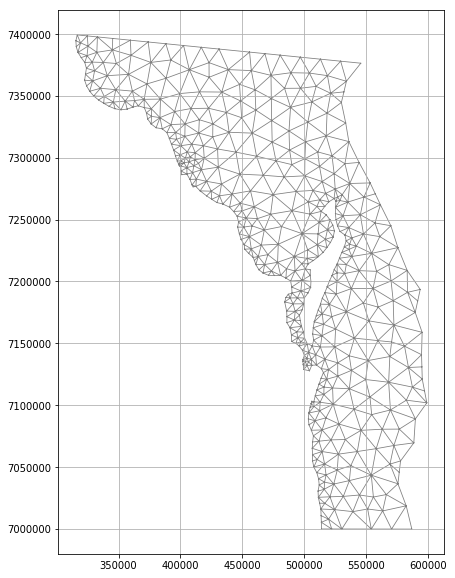

In [12]:
# Plotting accepts matplotlib.triplot kwargs
kwargs = dict(color='grey', linewidth=0.8)

f1, a1 = m.plot_mesh(kwargs=kwargs)
f1.set_size_inches(10,10)
a1.grid()
a1.set_aspect('equal')
plt.show()

Plotting the bathy

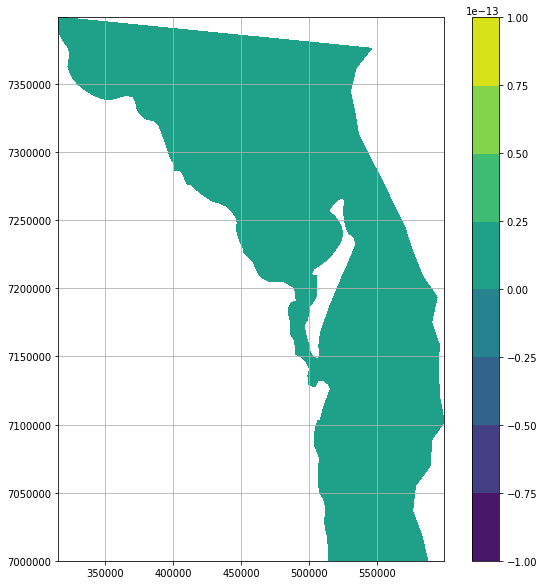

In [13]:
# Set fill=True to plot the mesh elevation
f2, a2, tf2 = m.plot_mesh(fill=True)
f2.set_size_inches(10,10)
a2.grid()
a2.set_aspect('equal')

f2.colorbar(tf2)
plt.show()

The bathymetry is just zero, since we have not interpolated any elevation data yet

## Interpolate DEM to Mesh

*Only a small section of the mesh will be interpolated to keep DEM file sizes reasonable.*

To interpolate, parse a list containing file path to each raster to interpolate. The order is important. Interpolation will be performed sequentially in the order that the rasters are in the list.

Given the **dem list**:

In [14]:
dem_data

['data\\DEM\\bathy_100m.tif', 'data\\DEM\\bathy_30m.tif']

This contains two rasters of varying resolution. The first is `bathy_100m` which has ~100m resolution and is interpolated first, then `bathy_30m` at ~30m resolution is interpolated. It does not matter if the raster does not encompass the entire mesh, interpolation will be performed only where the mesh and raster overlap for each respective raster.

This allows multiple rasters of varying coverage and resolution to be interpolated to a model mesh, so that areas of higher mesh resolution can consider higher resolution DEMs and vice-versa. 

Patching can also be performed, where, say, a small region of the mesh requires further attention to an already interpolated mesh. Interpolating this new region will only update those areas and leave non-overlapping areas untouched.

**Interpolate the rasters**:

In [15]:
m.interpolate_rasters(dem_data)

This updates the node z value mesh object for nodes that overlapped with the input rasters

Inspect interpolated region

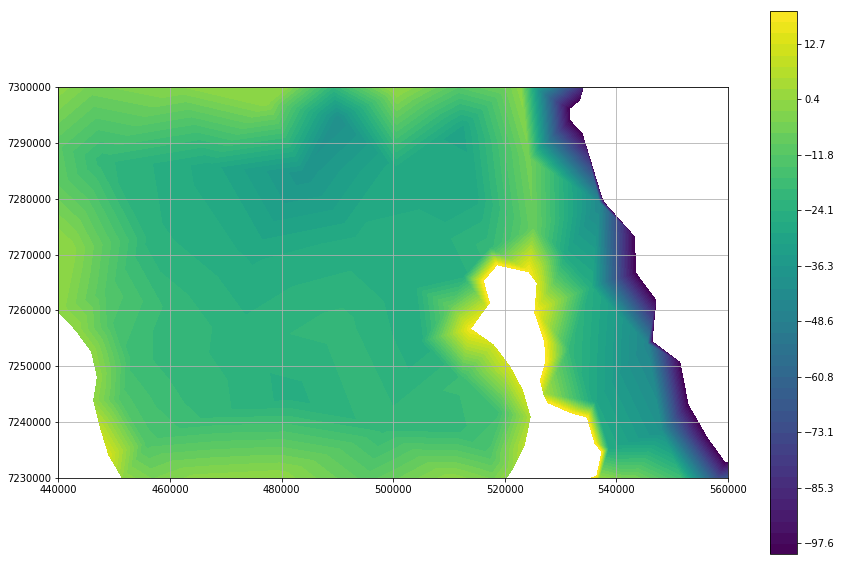

In [16]:
f3, a3, = plt.subplots()

t = tri.Triangulation(m.nodes[:,0], m.nodes[:,1], m.element_table-1)
tf3 = a3.tricontourf(t, m.nodes[:,2], vmin=-100, vmax=20, extend='neither', levels=np.linspace(-100,20))

f3.set_size_inches(15,10)
a3.grid()
a3.set_aspect('equal')

a3.set_xlim(440000, 560000)
a3.set_ylim(7230000, 7300000)
f3.colorbar(tf3)

plt.show()

## Save Interpolated Mesh

Call the `write_mesh()` method parsing in the output path for the `.mesh`

In [17]:
out_mesh = 'data/interpolated_mesh.mesh'
m.write_mesh(out_mesh)